# Project 59 Shape Classification

## Authors: Julen Etxaniz and Ibon Urbina

## Objectives: The goal of the project is to compare different classification algorithms on the solution of one or more shape datasets. 

## What is done in the Notebook: 
### Importing the libraries
### Reading the datasets
### Processing the dataset
### Preparing data for classification
### Dividing dataset in train and test sets for validation
### Defining the classifiers
### Learning the classifiers
### Using the classifier for predictions

# Importing the libraries
 We start by importing all relevant libraries to be used in the notebook.
    

In [544]:
import os
import matplotlib.pyplot as plt
from scipy.io import loadmat
import re

import pandas as pd
import numpy as np

from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Reading the datasets
We read the plane and car datasets

## Reading the plane dataset
We read the 210 files that contain the instances of the plane classification problem.

We concatenate all the instances in a unique dataframe called "plane_mats".

In [545]:
plane_dir = "../shape_dataset/plane_data/"
plane_mats = []
for file in os.listdir(plane_dir) :
    plane_mats.append(loadmat(plane_dir + file))

We plot one plane of each shape.

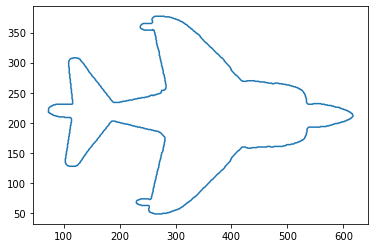

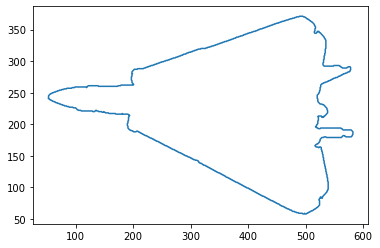

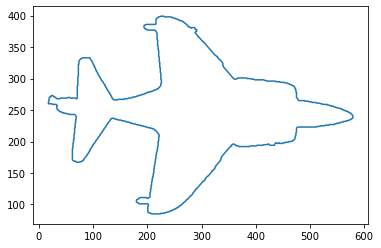

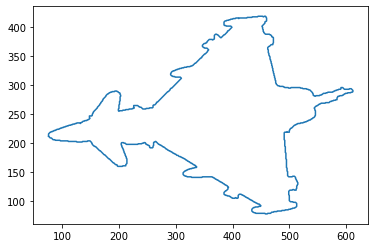

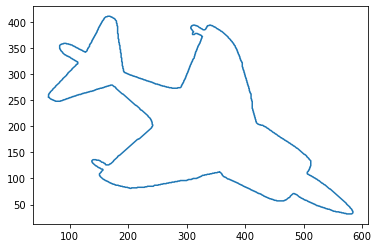

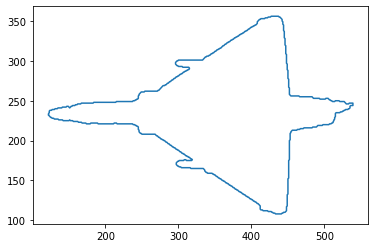

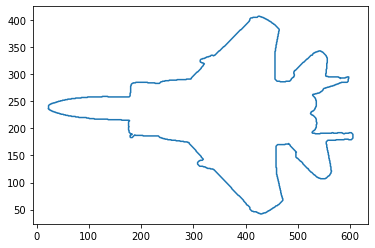

In [546]:
for i in range(7):
    plane = plane_mats[i*30]
    x = plane['x'][:,0]
    y = plane['x'][:,1]
    plt.plot(x, y)
    plt.show()

We check the dataset is correct, looking at the number of samples

In [547]:
print('The number of samples in the plane dataset is', len(plane_mats))

The number of samples in the plane dataset is 210


## Reading the car dataset
We read the 120 files that contain the instances of the car classification problem.

We concatenate all the instances in a unique dataframe called "car_mats"

In [586]:
car_dir = "../shape_dataset/car_data/"
car_mats = []
for file in os.listdir(car_dir) :
    car_mats.append(loadmat(car_dir + file))

In [587]:
# Ibon
car_dir = "../shape_dataset/car_data/"
car_mats = []
car_mats_file_name = []

for file in os.listdir(car_dir) :
    #print(file)
    # To know in which order are we reading the files
    car_mats_file_name.append(file)
    car_mats.append(loadmat(car_dir + file))

We check the dataset is correct, looking at the number of samples

In [588]:
print('The number of samples in the car dataset is', len(car_mats))

The number of samples in the car dataset is 120


# Preprocessing the car dataset

In this problem there are four classes that correspond to the types of cars:  sedan, pickup, minivan, or SUV. However, in the database files are written like this: "ClassX_SampleY.mat", where X is the corresponding class number and Y the corresponding sample number. 

Here is the correspondance of class number and class name (car model name):
* number 0 = sedan
* number 1 = pickup
* number 2 = minivan
* number 3 = SUV

One of the best ways to represent data are pandas DataFrames. Either for their flexibility and eassy management of information. That's what we are going to do in the next cell: convert the list where we read all the car data to a DataFrame called car_df.

In [589]:
# Ibon
car_df = pd.DataFrame(car_mats)

This is the way car_df DataFrame looks like:


In [590]:
# Ibon
car_df

,__header__,__version__,__globals__,x
0,"b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...",1.0,[],"[[206, 160], [207, 160], [208, 160], [209, 159..."
1,"b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...",1.0,[],"[[199, 175], [200, 175], [201, 174], [202, 174..."
2,"b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...",1.0,[],"[[75, 186], [76, 185], [76, 184], [76, 183], [..."
3,"b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...",1.0,[],"[[76, 183], [77, 183], [78, 183], [79, 182], [..."
4,"b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...",1.0,[],"[[113, 181], [114, 180], [114, 179], [114, 178..."
...,...,...,...,...
115,"b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...",1.0,[],"[[39, 178], [40, 177], [41, 177], [42, 178], [..."
116,"b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...",1.0,[],"[[145, 176], [146, 176], [147, 175], [147, 174..."
117,"b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...",1.0,[],"[[4, 200], [5, 199], [6, 198], [7, 198], [8, 1..."
118,"b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...",1.0,[],"[[54, 184], [55, 183], [56, 183], [57, 183], [..."


As we see in the image above, __header__, __version__ and __globals__ columns are values created when using loadmat function to be able to read .mat files.

Those columns are not useful. We are going to delete them.

In [591]:
# Ibon
car_df = car_df.drop(['__header__', '__version__', '__globals__'], axis=1)
car_df

,x
0,"[[206, 160], [207, 160], [208, 160], [209, 159..."
1,"[[199, 175], [200, 175], [201, 174], [202, 174..."
2,"[[75, 186], [76, 185], [76, 184], [76, 183], [..."
3,"[[76, 183], [77, 183], [78, 183], [79, 182], [..."
4,"[[113, 181], [114, 180], [114, 179], [114, 178..."
...,...
115,"[[39, 178], [40, 177], [41, 177], [42, 178], [..."
116,"[[145, 176], [146, 176], [147, 175], [147, 174..."
117,"[[4, 200], [5, 199], [6, 198], [7, 198], [8, 1..."
118,"[[54, 184], [55, 183], [56, 183], [57, 183], [..."


Now, the only attribute available in our car DataFrame is x, which refers to cartesian coordinates of each point on the perimeter of the shape. We need more information to include there, such as class value and sample number.

In [592]:
# Ibon

# Remember we have the names of the files read (in order) in our list called car_mats_file_name.
# Lets, divide that array in two arrays. One containing the class number and the other the sample number.

sample_n = []
class_n = []

for i in car_mats_file_name:
    class_n.append(int(re.findall(r'\d+', str(i))[0]))
    sample_n.append(int(re.findall(r'\d+', str(i))[1]))


In [593]:
# Ibon
print("This is how our sample_n looks like: \n")
np.array(sample_n)

This is how our sample_n looks like: 



array([10,  1, 17, 18,  1, 17, 27, 30, 17,  5, 18, 30, 16, 14, 27, 24, 21,
       10,  3, 27, 15, 19, 26, 19, 22,  9, 20, 13,  7, 10, 22, 23, 19,  2,
       30, 15,  9, 20, 27, 11,  9, 23,  6, 12,  2, 20,  3,  3, 13, 24, 21,
        2,  5, 29, 29,  1, 28,  5, 12, 16,  4, 26, 30,  8, 22, 15,  4, 28,
        6, 21, 24, 16, 21, 11,  7, 10, 26,  7, 28, 23, 11,  7, 14,  8, 14,
        9,  1, 29, 17,  4, 18, 20, 15, 26,  8, 19, 12,  4, 25, 13, 29,  2,
       28, 14, 25, 24, 22, 25, 16,  6,  8,  5, 25,  3, 13,  6, 11, 23, 12,
       18])

In [594]:
# Ibon
print("This is how our class_n looks like: \n")
np.array(class_n)

This is how our class_n looks like: 



array([3, 4, 2, 2, 1, 4, 4, 1, 1, 1, 3, 3, 2, 3, 2, 1, 3, 1, 1, 3, 2, 4,
       1, 3, 4, 2, 3, 1, 3, 4, 3, 1, 2, 4, 2, 3, 3, 4, 1, 3, 4, 2, 2, 4,
       1, 1, 3, 2, 2, 2, 1, 2, 4, 4, 2, 3, 1, 3, 2, 1, 1, 4, 4, 1, 2, 1,
       2, 4, 3, 4, 3, 3, 2, 2, 1, 2, 2, 2, 2, 4, 1, 4, 1, 4, 2, 1, 2, 1,
       3, 3, 1, 2, 4, 3, 2, 1, 3, 4, 2, 4, 3, 3, 3, 4, 1, 4, 1, 3, 4, 4,
       3, 2, 4, 4, 3, 1, 4, 3, 1, 4])

Lets add those lists to the car DataFrame.

In [595]:
# Ibon
car_df['Class'] = class_n
car_df['Sample'] = sample_n
print("This is, finally, how our car dataFrame looks like: \n")
car_df

This is, finally, how our car dataFrame looks like: 



,x,Class,Sample
0,"[[206, 160], [207, 160], [208, 160], [209, 159...",3,10
1,"[[199, 175], [200, 175], [201, 174], [202, 174...",4,1
2,"[[75, 186], [76, 185], [76, 184], [76, 183], [...",2,17
3,"[[76, 183], [77, 183], [78, 183], [79, 182], [...",2,18
4,"[[113, 181], [114, 180], [114, 179], [114, 178...",1,1
...,...,...,...
115,"[[39, 178], [40, 177], [41, 177], [42, 178], [...",1,6
116,"[[145, 176], [146, 176], [147, 175], [147, 174...",4,11
117,"[[4, 200], [5, 199], [6, 198], [7, 198], [8, 1...",3,23
118,"[[54, 184], [55, 183], [56, 183], [57, 183], [...",1,12


## Classes are balanced? Yes

Although in the description of the database it is said that each class has 30 samples, to make sure about it we are going to count them.

In [596]:
# We have 4 classes in car database
class_1  = list(car_df['Class']==1).count(True)
class_2 = list(car_df['Class']==2).count(True)
class_3 = list(car_df['Class']==3).count(True)
class_4 = list(car_df['Class']==4).count(True)

print("Quantity of samples in each class: \n Class1: " + str(class_1) + 
      "\n Class2: " + str(class_2) + "\n Class3: " + str(class_3) + "\n Class4: " + str(class_4))

Quantity of samples in each class: 
 Class1: 30
 Class2: 30
 Class3: 30
 Class4: 30


## Let's add another feature to our database

As we mention before, the only feature descriptor of the shapes is x, which  which refers to cartesian coordinates of each point on the perimeter of the shape. However, how many points are in each contour perimeter is not taken as a unique feature. It is implicitly measure in the length of each x sample, but, we prefer make it explicit.

In [597]:
length_list = []
for i in range(len(car_df)):
    length_list.append(len(car_df['x'][i]))
    
car_df['Perimeter_length'] = length_list

In [598]:
print("This is how our car dataFrame looks like: \n")
car_df

This is how our car dataFrame looks like: 



,x,Class,Sample,Perimeter_length
0,"[[206, 160], [207, 160], [208, 160], [209, 159...",3,10,325
1,"[[199, 175], [200, 175], [201, 174], [202, 174...",4,1,375
2,"[[75, 186], [76, 185], [76, 184], [76, 183], [...",2,17,511
3,"[[76, 183], [77, 183], [78, 183], [79, 182], [...",2,18,525
4,"[[113, 181], [114, 180], [114, 179], [114, 178...",1,1,310
...,...,...,...,...
115,"[[39, 178], [40, 177], [41, 177], [42, 178], [...",1,6,369
116,"[[145, 176], [146, 176], [147, 175], [147, 174...",4,11,339
117,"[[4, 200], [5, 199], [6, 198], [7, 198], [8, 1...",3,23,578
118,"[[54, 184], [55, 183], [56, 183], [57, 183], [...",1,12,334


## Changing how x feature is represented

When learning a classifier is useful to have features as arrays of numbers, and not as arrays of sequences. In our case, x is an array of (x, y) coordinates; so we are going to separate x and y, an then create two extra features from there.

In [599]:
x_coordinates = []
y_coordinates = []

for i in range(len(car_df['x'])):
    x_coordinates.append(np.resize((car_df['x'][i])[:,0], (300, 1)))
    y_coordinates.append(np.resize((car_df['x'][i])[:,1], (300, 1)))

In [600]:
x_stack = x_coordinates[0]
y_stack = y_coordinates[0]
for i in range(len(x_coordinates)-1):
    x_stack = np.column_stack((x_stack, x_coordinates[i+1]))
    y_stack = np.column_stack((y_stack, y_coordinates[i+1]))
x_stack

array([[206, 199,  75, ...,   4,  54, 126],
       [207, 200,  76, ...,   5,  55, 127],
       [208, 201,  76, ...,   6,  56, 128],
       ...,
       [232, 240, 261, ..., 241,  80, 301],
       [231, 239, 260, ..., 241,  79, 300],
       [230, 238, 259, ..., 241,  78, 299]], dtype=uint16)

In [601]:
# Insert those columns in the car dataFrame
for i in range(len(x_stack)):
    stringX = "x" + str(i)
    stringY = "y" + str(i)
    car_df[stringX] = x_stack[i]
    car_df[stringY] = y_stack[i]
car_df

,x,Class,Sample,Perimeter_length,x0,y0,x1,y1,x2,y2,...,x295,y295,x296,y296,x297,y297,x298,y298,x299,y299
0,"[[206, 160], [207, 160], [208, 160], [209, 159...",3,10,325,206,160,207,160,208,160,...,234,162,233,162,232,162,231,162,230,162
1,"[[199, 175], [200, 175], [201, 174], [202, 174...",4,1,375,199,175,200,175,201,174,...,242,187,241,187,240,187,239,188,238,188
2,"[[75, 186], [76, 185], [76, 184], [76, 183], [...",2,17,511,75,186,76,185,76,184,...,263,193,262,193,261,193,260,193,259,193
3,"[[76, 183], [77, 183], [78, 183], [79, 182], [...",2,18,525,76,183,77,183,78,183,...,286,193,285,193,284,193,283,193,282,193
4,"[[113, 181], [114, 180], [114, 179], [114, 178...",1,1,310,113,181,114,180,114,179,...,125,186,124,186,123,186,122,185,121,185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,"[[39, 178], [40, 177], [41, 177], [42, 178], [...",1,6,369,39,178,40,177,41,177,...,89,188,88,188,87,189,86,190,85,190
116,"[[145, 176], [146, 176], [147, 175], [147, 174...",4,11,339,145,176,146,176,147,175,...,172,190,171,191,170,190,169,190,168,190
117,"[[4, 200], [5, 199], [6, 198], [7, 198], [8, 1...",3,23,578,4,200,5,199,6,198,...,241,160,241,161,241,162,241,163,241,164
118,"[[54, 184], [55, 183], [56, 183], [57, 183], [...",1,12,334,54,184,55,183,56,183,...,82,192,81,192,80,192,79,192,78,192


# Preparing data for classification

To learn the classifiers, we need to separate in two different sets the features and the classes. 


In [602]:
# The selected features are: 'Perimeter_length', 'xJ' and 'yJ'  (J -> [0, 299])
features = car_df.drop(columns=['x', 'Class', 'Sample'])
features

,Perimeter_length,x0,y0,x1,y1,x2,y2,x3,y3,x4,...,x295,y295,x296,y296,x297,y297,x298,y298,x299,y299
0,325,206,160,207,160,208,160,209,159,210,...,234,162,233,162,232,162,231,162,230,162
1,375,199,175,200,175,201,174,202,174,203,...,242,187,241,187,240,187,239,188,238,188
2,511,75,186,76,185,76,184,76,183,76,...,263,193,262,193,261,193,260,193,259,193
3,525,76,183,77,183,78,183,79,182,80,...,286,193,285,193,284,193,283,193,282,193
4,310,113,181,114,180,114,179,114,178,114,...,125,186,124,186,123,186,122,185,121,185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,369,39,178,40,177,41,177,42,178,43,...,89,188,88,188,87,189,86,190,85,190
116,339,145,176,146,176,147,175,147,174,148,...,172,190,171,191,170,190,169,190,168,190
117,578,4,200,5,199,6,198,7,198,8,...,241,160,241,161,241,162,241,163,241,164
118,334,54,184,55,183,56,183,57,183,58,...,82,192,81,192,80,192,79,192,78,192


Then we are going to put all Classes in a unique structure.

In [603]:
# Ibon
target = car_df['Class']
target

0      3
1      4
2      2
3      2
4      1
      ..
115    1
116    4
117    3
118    1
119    4
Name: Class, Length: 120, dtype: int64

# Dividing dataset in train and test  sets for validation

Also, to evaluate the accuracy of the classifiers in the dataset we will split the data in two sets. Train and Test data. 
Each set will have the same number of samples of each class (15).

In [604]:
# Ibon

# We divide the dataset for the first subject in training and test data. Even rows are in the train set 
# and odd rows in the test set. 

# Train set 
train_features = features[0::2]
train_target = target[0::2]
train_n_samples = len(train_target)

# Test set
test_features = features[1::2]
test_target = target[1::2]
test_n_samples = len(test_target)


# Defining the classifiers
We define the three classifiers used.

In [605]:
dt  = DecisionTreeClassifier()
lda = LinearDiscriminantAnalysis()
lg  = LogisticRegression()

# Learning the classifiers
We used the train data to learn the three classifiers

In [606]:
# Ibon

dt.fit(train_features, train_target)
lda.fit(train_features, train_target)
lg.fit(train_features, train_target)

/home/ibon/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

# Using the classifier for predictions
We predict the class of the samples in the test data with the three classifiers.

In [607]:
# Ibon

dt_test_predictions = dt.predict(test_features)
lda_test_predictions = lda.predict(test_features)
lg_test_predictions = lg.predict(test_features)

# Computing the accuracy

Finally, we compute the accuracy using the three classifiers and print it. 

In [608]:
# Ibon

dt_acc =  accuracy_score(test_target, dt_test_predictions)
lda_acc =  accuracy_score(test_target, lda_test_predictions)
lg_acc =  accuracy_score(test_target, lg_test_predictions)
print("Accuracy for the decision tree :",dt_acc)
print("Accuracy for LDA :",lda_acc)
print("Accuracy for logistic regression:",lg_acc)

Accuracy for the decision tree : 0.7666666666666667
Accuracy for LDA : 0.8333333333333334
Accuracy for logistic regression: 0.8333333333333334


# Computing the confusion matrices
Finally we compute the confusion matrices for the three classifiers. We print the confusion matrices and also generate the latex code to insert it in our written report. 


In [609]:
print("Confusion matrix decision tree")
cm_dt = pd.crosstab(test_target, dt_test_predictions)
print(cm_dt)
#cm_dt.to_latex()

Confusion matrix decision tree
col_0   1  2   3   4
Class               
1      13  1   0   0
2       0  8   2   1
3       0  3  11   0
4       0  4   3  14


In [610]:
print("Confusion matrix LDA")
cm_lda = pd.crosstab(test_target, lda_test_predictions)
print(cm_lda)
#cm_lda.to_latex()

Confusion matrix LDA
col_0   1   2   3   4
Class                
1      13   1   0   0
2       0  11   0   0
3       0   3  10   1
4       2   0   3  16


In [611]:
print("Confusion matrix Logistic regression")
cm_lg = pd.crosstab(test_target, lg_test_predictions)
print(cm_lg)
#cm_lg.to_latex()

Confusion matrix Logistic regression
col_0   1   2   3   4
Class                
1      12   1   0   1
2       1  10   0   0
3       0   1  13   0
4       0   1   5  15


In [612]:
##Applying Gaussian filter to our shapes
# Filtered with Gaussian filter (standar deviation = 10).
# Gaussian filter: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html
#for i in range(len(car_df['Contour_Coordinates'])):
#    car_df.at[i, 'Contour_Coordinates'] = gaussian_filter(np.array(car_df['Contour_Coordinates'][i]), sigma=10)
#print("This how our shapes filtered look like: \n")
#car_df